# Run simulation using parameters estimated from Kay et al., 2015

In this notebook we'll be simulating what we think it's happening at the neural level to reduce the retinotopic bias found in the two behavioral experiments. We took the VTC data available from http://kendrickkay.net/vtcdata/, ran their CSS model (http://kendrickkay.net/socmodel/) using the same methods as in the paper, and stored the estimated parameters for every voxel that had a test performance greater than 50% (see their paper).

As in the original paper, the voxels are aggregated across participants for each ROI, and we also aggregate hemispheres. The simulation then randomly samples the voxels from this population of estimated parameters. For all simulations, we assume two population of neural units, each specifically responsive to a particular identity. We activate the populations when presenting the stimuli at the location of our experiments, and use these activity patterns to train a classifier to distinguish between the two identities. Then, we present morphed identities and use the classifier to distinguish between the identities at each stimulus location. Using the classifier's responses we build a psychometric fit, and store the PSE. 

In this way, we perform the following experiments:

1. We increase the number of units responsive to the first identity, while keeping only one unit responsive to the second identity, using the estimated parameters
2. Same as 1., but we fix the gain for all voxels to $1.$
3. We keep the gain for the unit responsive to the second identity set to $1.$, and parametrically increase the gain for those units responsive to the first identity
4. We fix the gain for all units to $1.$, and we parametrically increase the receptive field size for the units responsive to the first identity

Experiments 3. and 4. are performed in order to check whether changes in unit parameters can also account for the reduced biases.

Note that this notebook was used to prototype the final script. Please check the file `run_simulation_vtcdata.py` for the script.

In [1]:
from cssmodel.simulation import *
import os.path as op
%matplotlib inline
import seaborn as sns
from joblib.parallel import Parallel, delayed
import seaborn as sns
from sklearn.utils.extmath import cartesian
sns.set_style('white')

In [2]:
# define the scale from degrees to pixels
# we fitted the model with stimuli that lived in a 100x100 pix square
# and in the actual experiment the width was 12.5˚
# thus deg2pix = 100/12.5 = 8
# because our stimuli where centered at around 7˚, we are going to use a 200x200 square
# so they'll fit in the "screen"
deg2pix = 100/12.5
res = 200

In [3]:
# make stimuli
stimuli = make_stimuli(scale=deg2pix, res=res)

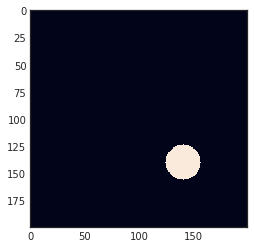

In [4]:
plt.imshow(stimuli[0])

In [5]:
def compute_varpse(pses, avg=0.5):
    return np.sum((pses - avg)**2, axis=1)

In [6]:
from matplotlib.patches import Ellipse

def draw_stimuli(ax, scale=4., res=100):
    x0 = y0 = res // 2
    w = 4 * scale
    h = 4 * scale
    xpos = np.array((5, -5, -5, 5)) * scale + x0
    ypos = np.array((5, 5, -5, -5)) * scale + y0
    els = [
        Ellipse([x, y], width=w, height=h, facecolor='white', alpha=0.8) for x, y in zip(xpos, ypos)]
    for e in els:
        e.set_clip_box(ax.bbox)
        ax.add_artist(e)

In [7]:
rois = ['V1', 'V2', 'V3', 'hV4', 'IOG', 'pFus', 'mFus']
data = dict()
data_combined = dict()
for h in ['L', 'R']:
    for roi in rois:
        roi_name = f'{h}{roi}'
        # remove the center from x, y so they're centered in (0, 0)
        dt = np.loadtxt(f'../vtcdata/output/{roi_name}_median_param.txt')
        dt[:2] -= 50
        data[roi_name] = dt
for roi in rois:
    data_combined[roi] = np.hstack((data[f'L{roi}'], data[f'R{roi}']))

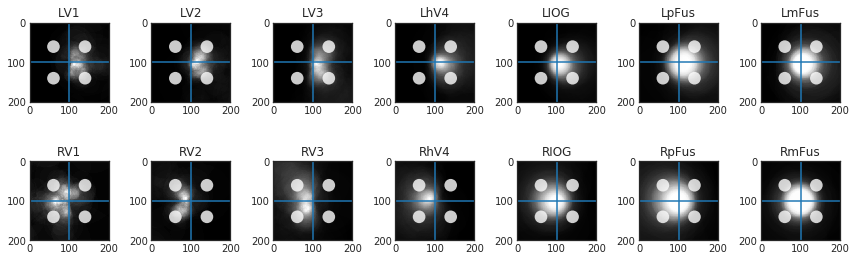

In [8]:
fig, axs = plt.subplots(2, 7, figsize=(12, 4))
for i, hemi in enumerate(['L', 'R']):
    axs_ = axs[i]
    for ax, roi in zip(axs_, rois):
        roi_name = f'{hemi}{roi}'
        dt = data[roi_name]
        plot_prfdensity(dt[1], dt[0], dt[2], n=dt[-1], ax=ax, res=res)
        ax.set_title(roi_name)
        draw_stimuli(ax, scale=deg2pix, res=res)
plt.tight_layout()

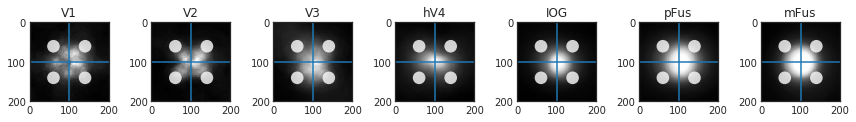

In [9]:
fig, axs = plt.subplots(1, 7, figsize=(12, 4))
for ax, roi in zip(axs, rois):
    dt = data_combined[roi]
    plot_prfdensity(dt[1], dt[0], dt[2], n=dt[-1], ax=ax, res=res)
    ax.set_title(roi)
    draw_stimuli(ax, scale=deg2pix, res=res)
plt.tight_layout()

# 1. Increasing number of units with estimated parameters

In [10]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)
n_voxels = 1 + ratios

In [11]:
rois = [
    #'V1', 'V2', 'V3', 'hV4', 
    'IOG', 'pFus', 'mFus'
]

In [12]:
comb_search = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

In [13]:
comb_search[:10]

[('IOG', 1, 2),
 ('IOG', 2, 3),
 ('IOG', 3, 4),
 ('IOG', 4, 5),
 ('IOG', 5, 6),
 ('IOG', 6, 7),
 ('IOG', 7, 8),
 ('IOG', 8, 9),
 ('IOG', 9, 10),
 ('pFus', 1, 2)]

In [14]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(245)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [19]:
out_gain = Parallel(n_jobs=32, verbose=5)(
    delayed(simulate_bunch_experiments_population)
    (data_combined[r], stimuli=stimuli, ratio_voxels=ratio, n_voxels=nvx, n_sim=500, sigma_noise=0.1, res=res) 
    for r in rois for (ratio, nvx) in zip(ratios, n_voxels))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  7.9min remaining: 27.6min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  7.9min remaining:  9.9min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.0min remaining:  4.0min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.0min remaining:   59.8s
[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.0min finished


In [20]:
out = out_gain
dfs, pses, ts, params = zip(*out)
varpses = [compute_varpse(p) for p in pses]

In [21]:
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(
    [(ratio, r) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)], names=['ratio', 'roi'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

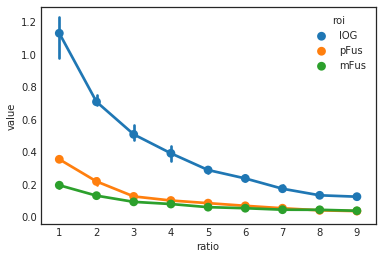

In [22]:
sns.pointplot(x='ratio', y='value', hue='roi', 
              data=df_varp, 
              order=df_varp.ratio.unique(), ci=68, estimator=np.median)

In [16]:
df_varp.to_csv(op.join('outputs', 'sim-01_increase_units_500sim.csv'))

# 2. Fix gains to 1.

In [21]:
# fix the gain to 1
data_combined_fixgain = dict()
for r, pp in data_combined.items():
    p = pp.copy()
    p[3] = 1.
    data_combined_fixgain[r] = p

In [18]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(245)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [19]:
out_fixgain = Parallel(n_jobs=32, verbose=5)(
    delayed(simulate_bunch_experiments_population)
    (data_combined_fixgain[r], stimuli=stimuli, n_sim=500, ratio_voxels=ratio, n_voxels=nvx, sigma_noise=0.1) 
    for r in rois for (ratio, nvx) in zip(ratios, n_voxels))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  8.5min remaining: 29.9min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  8.6min remaining: 10.7min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.6min remaining:  4.3min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.6min remaining:  1.1min
[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.6min finished


In [20]:
out = out_fixgain
dfs, pses, ts, params = zip(*out)
varpses = [compute_varpse(p) for p in pses]

In [21]:
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(
    [(ratio, r) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)], names=['ratio', 'roi'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

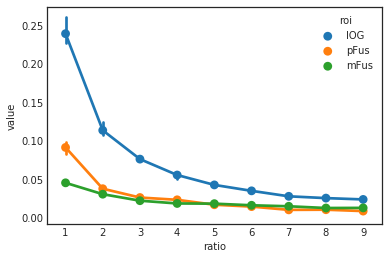

In [22]:
sns.pointplot(x='ratio', y='value', hue='roi', 
              data=df_varp, 
              order=df_varp.ratio.unique(), ci=68, estimator=np.median)

In [23]:
df_varp.to_csv(op.join('outputs', 'sim-02_increase_units_fixgain_500sim.csv'))

# 3. Increase gains

In [24]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)
n_voxels = 1 + ratios

In [25]:
ratio_nvox = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

In [26]:
gains = np.arange(1, 4.25, 0.5)
gains

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [27]:
comb_search = [(r, ratio, nvx, g) for g in gains for (r, ratio, nvx) in ratio_nvox]

In [28]:
comb_search[:10]

[('IOG', 1, 2, 1.0),
 ('IOG', 2, 3, 1.0),
 ('IOG', 3, 4, 1.0),
 ('IOG', 4, 5, 1.0),
 ('IOG', 5, 6, 1.0),
 ('IOG', 6, 7, 1.0),
 ('IOG', 7, 8, 1.0),
 ('IOG', 8, 9, 1.0),
 ('IOG', 9, 10, 1.0),
 ('pFus', 1, 2, 1.0)]

In [29]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(98698)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [30]:
out_ingain = Parallel(n_jobs=32, verbose=5)(delayed(simulate_bunch_experiments_population)
    (data_combined_fixgain[r], stimuli=stimuli, ratio_voxels=ratio, n_sim=500,
     sigma_noise=0.1, scale_gain=g, n_voxels=nvx, master_seed=seed) 
    for (r, ratio, nvx, g), seed in zip(comb_search, master_seeds))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed: 11.7min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed: 44.4min
[Parallel(n_jobs=32)]: Done 164 out of 189 | elapsed: 64.8min remaining:  9.9min
[Parallel(n_jobs=32)]: Done 189 out of 189 | elapsed: 65.3min finished


In [31]:
dfs, pses, ts, params = zip(*out_ingain)
varpses = [compute_varpse(p) for p in pses]

In [32]:
index_df = [(c[0], c[1], c[3]) for c in comb_search]
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(index_df, names=['roi', 'ratio', 'gain'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

In [33]:
df_varp.to_csv(op.join('outputs', 'sim-03_increase_gains_500sim.csv'))

In [34]:
d = df_varp[df_varp.roi == 'IOG']
#d = df_varp[df_varp.gain == 1.0]

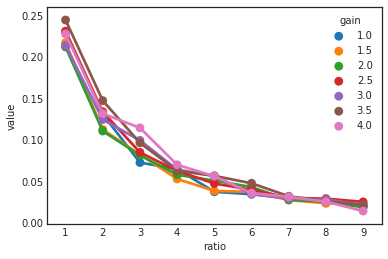

In [35]:
sns.pointplot(x='ratio', y='value', hue='gain', 
              data=d, 
              order=d.ratio.unique(), ci=False, estimator=np.median)

# 4. Increase receptive field sizes

In [13]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)
n_voxels = 1 + ratios

In [14]:
ratio_nvox = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

In [15]:
rf_increase = np.arange(0, 0.55, 0.1)
rf_increase

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [16]:
comb_search = [(r, ratio, nvx, rfi) for rfi in rf_increase for (r, ratio, nvx) in ratio_nvox]

In [17]:
comb_search[:10]

[('IOG', 1, 2, 0.0),
 ('IOG', 2, 3, 0.0),
 ('IOG', 3, 4, 0.0),
 ('IOG', 4, 5, 0.0),
 ('IOG', 5, 6, 0.0),
 ('IOG', 6, 7, 0.0),
 ('IOG', 7, 8, 0.0),
 ('IOG', 8, 9, 0.0),
 ('IOG', 9, 10, 0.0),
 ('pFus', 1, 2, 0.0)]

In [18]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(98698)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [22]:
out_rfin = Parallel(n_jobs=32, verbose=5)(delayed(simulate_bunch_experiments_population)
    (data_combined_fixgain[r], stimuli=stimuli, ratio_voxels=ratio, n_sim=500,
     sigma_noise=0.1, increase_rf_size=rfi, n_voxels=nvx, master_seed=seed) 
    for (r, ratio, nvx, rfi), seed in zip(comb_search, master_seeds))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed: 11.3min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed: 45.3min
[Parallel(n_jobs=32)]: Done 132 out of 162 | elapsed: 56.5min remaining: 12.9min
[Parallel(n_jobs=32)]: Done 162 out of 162 | elapsed: 57.4min finished


In [23]:
dfs, pses, ts, params = zip(*out_rfin)
varpses = [compute_varpse(p) for p in pses]

In [24]:
index_df = [(c[0], c[1], c[3]) for c in comb_search]
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(index_df, names=['roi', 'ratio', 'rf_increase'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

In [25]:
df_varp.to_csv(op.join('outputs', 'sim-04_increase_rf_500sim.csv'))

In [30]:
d = df_varp[df_varp.roi == 'mFus']
#d = df_varp[df_varp.gain == 1.0]

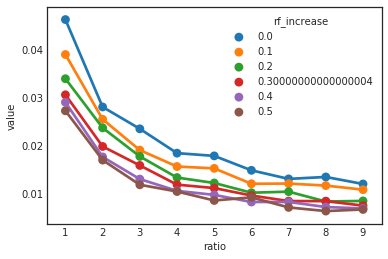

In [31]:
sns.pointplot(x='ratio', y='value', hue='rf_increase', 
              data=d, 
              order=d.ratio.unique(), ci=False, estimator=np.median)

# 5. Increase overall number of voxels and run with fixed gain

In [57]:
units_responsive_b = range(1, 6)

In [58]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)


In [59]:
rois = [
    #'V1', 'V2', 'V3', 'hV4', 
    'IOG', 'pFus', 'mFus'
]

In [64]:
out_fixgain_morevox = dict()
df_varp_morevox = []
for urb in units_responsive_b:
    n_voxels = (1 + ratios) * urb
    print(f"Using n_voxels: {n_voxels}")
    comb_search = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

    out = Parallel(n_jobs=32, verbose=5)(
        delayed(simulate_bunch_experiments_population)
        (data_combined_fixgain[r], stimuli=stimuli, n_sim=500, ratio_voxels=ratio, n_voxels=nvx, sigma_noise=0.1) 
        for r in rois for (ratio, nvx) in zip(ratios, n_voxels))
    out_fixgain_morevox[urb] = out

    dfs, pses, ts, params = zip(*out)
    varpses = [compute_varpse(p) for p in pses]

    df_varp = pd.DataFrame(varpses)
    df_varp.index = pd.MultiIndex.from_tuples(
        [(ratio, r) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)], names=['ratio', 'roi'])
    # df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
    df_varp = df_varp.T
    df_varp = pd.melt(df_varp)
    
    df_varp['b_units'] = urb
    df_varp_morevox.append(df_varp)

Using n_voxels: [ 2  3  4  5  6  7  8  9 10]


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  8.7min remaining: 30.6min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  8.8min remaining: 11.0min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.8min remaining:  4.4min


Using n_voxels: [ 4  6  8 10 12 14 16 18 20]


[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.8min remaining:  1.1min
[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.8min finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  8.4min remaining: 29.5min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  8.5min remaining: 10.6min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.5min remaining:  4.2min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.5min remaining:  1.1min


Using n_voxels: [ 6  9 12 15 18 21 24 27 30]


[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.5min finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  8.3min remaining: 28.9min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  8.3min remaining: 10.4min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.4min remaining:  4.2min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.4min remaining:  1.0min


Using n_voxels: [ 8 12 16 20 24 28 32 36 40]


[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.4min finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  7.9min remaining: 27.7min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  8.1min remaining: 10.1min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  8.2min remaining:  4.1min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.2min remaining:  1.0min


Using n_voxels: [10 15 20 25 30 35 40 45 50]


[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.3min finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of  27 | elapsed:  7.7min remaining: 27.0min
[Parallel(n_jobs=32)]: Done  12 out of  27 | elapsed:  7.9min remaining:  9.8min
[Parallel(n_jobs=32)]: Done  18 out of  27 | elapsed:  7.9min remaining:  4.0min
[Parallel(n_jobs=32)]: Done  24 out of  27 | elapsed:  8.0min remaining:   59.8s
[Parallel(n_jobs=32)]: Done  27 out of  27 | elapsed:  8.0min finished


In [66]:
df_varp_morevox = pd.concat(df_varp_morevox)

In [74]:
df = df_varp_morevox[df_varp_morevox.roi == 'pFus']

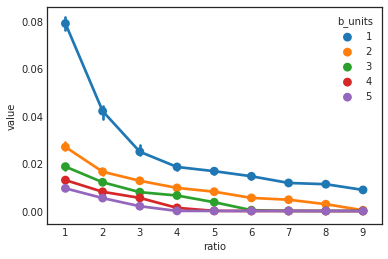

In [75]:
sns.pointplot(x='ratio', y='value', hue='b_units', 
              data=df, 
              order=df.ratio.unique(), ci=68, estimator=np.median)

In [76]:
df_varp_morevox.to_csv(op.join('outputs', 'sim-05_increase_units_fixgain_500sim_morevox.csv'))

# Plot example of PRFs covering more and more of the visual field

In [77]:
def plot_prfdensity(xs, ys, sigmas, n=0.2, res=100, ax=None):
    """
    Plot the coverage of a population of voxels

    Parameters
    ----------
    xs : array (n_voxels)
        centers
    ys : array (n_voxels)
        centers
    sigmas : array (n_voxels)
        std pRfs
    n : float
        power exponent
    res : int
        size of one of the sides
    ax : axis

    Returns
    -------
    ax : axis
    """
    x0 = y0 = res // 2
    xs = np.asarray(xs) + x0
    ys = np.asarray(ys) + y0

    f = np.zeros((res, res))
    for x, y, s in zip(xs, ys, sigmas):
        f += filledprf(x, y, s, n=n, res=res)
    f /= len(xs)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(f, aspect='equal', cmap='gray')
    ax.axhline(y0)
    ax.axvline(x0)
    return ax

In [78]:
def prfdensity(xs, ys, sigmas, n=0.2, res=100, ax=None):
    """
    Plot the coverage of a population of voxels

    Parameters
    ----------
    xs : array (n_voxels)
        centers
    ys : array (n_voxels)
        centers
    sigmas : array (n_voxels)
        std pRfs
    n : float
        power exponent
    res : int
        size of one of the sides
    ax : axis

    Returns
    -------
    ax : axis
    """
    x0 = y0 = res // 2
    xs = np.asarray(xs) + x0
    ys = np.asarray(ys) + y0

    f = np.zeros((res, res))
    for x, y, s in zip(xs, ys, sigmas):
        f += filledprf(x, y, s, n=n, res=res)
    f /= len(xs)

    return f

In [90]:
def plot_overlap_population(params, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    density_a = prfdensity(params['a'][0], params['a'][1], params['a'][2])
    density_b = prfdensity(params['b'][0], params['b'][1], params['b'][2])
    d = np.dstack((density_b, density_a, np.zeros((100, 100))))
    ax.imshow(d)
    return ax

In [91]:
from matplotlib.patches import Ellipse

def draw_stimuli(ax, scale=4., res=100):
    x0 = y0 = res // 2
    w = 4 * scale
    h = 4 * scale
    xpos = np.array((5, -5, -5, 5)) * scale + x0
    ypos = np.array((5, 5, -5, -5)) * scale + y0
    els = [
        Ellipse([x, y], width=w, height=h, facecolor='white', alpha=0.8) for x, y in zip(xpos, ypos)]
    for e in els:
        e.set_clip_box(ax.bbox)
        ax.add_artist(e)

In [93]:
def remove_ticks(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [94]:
def add_scale(ax, scale=4., res=100):
    y = res - scale*1
    x = res - scale*3
    ax.plot([x, x + scale], [y, y], 'white', solid_capstyle='projecting')
    # add text
    ax.text(x-1, y-2, '1$^\circ$ ', color='white', size=12, weight='heavy')

In [95]:
params[26][0]

{'a': array([[-6.24993664e-02,  1.73642696e+00, -1.28855228e+00,
         -1.51920254e+00,  2.42971841e+00,  5.75732805e+00,
         -4.78451676e-01, -6.35741173e+00,  3.71646229e+00,
         -8.99124983e-01, -1.08831788e+01,  3.02018969e-01,
          1.30938165e+00,  3.63178752e-01, -3.11660978e+00,
         -6.67768788e+00, -2.12931453e+00,  3.86874249e-01,
          5.44584032e-01, -3.08106155e+00, -4.03098307e+00,
         -1.57167338e+00,  2.68360629e+00,  4.57252961e+00,
          9.02880514e+00, -2.58959312e+00,  3.69755294e+00,
          1.04314054e+00,  1.57481129e+00,  2.47710892e-01,
          1.84284727e+00,  1.92441615e+00,  3.35387292e+00,
         -3.43625580e+00,  6.45394010e+00,  3.77474939e-01,
         -1.19588213e+00,  3.98582505e+00, -2.91004262e+00,
          4.10708143e+00,  1.04290858e+00,  1.60160396e+00,
         -4.54384087e+00, -3.95564069e+00,  5.87501964e+00],
        [ 1.41053271e+01, -6.46758291e+00,  4.66269596e+01,
         -4.68093270e+00,  1.08129

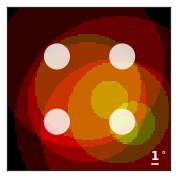

In [97]:
# params, _ = get_params_pop(*roi_values['IOG'], n_voxels=10, ratio_voxels=9)
params_ = params[0][0]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax = plot_overlap_population(params_, ax=ax)
draw_stimuli(ax)
remove_ticks(ax)
add_scale(ax)

In [102]:
params_['a'][:, 0]

array([17.54612608, 14.43207222,  6.94922749,  1.        ,  0.35270163])

Save figures showing example building up of coverage -- basically what we're modeling

In [ ]:
import os.path as op
import os

In [ ]:
img_dir = 'img'
if not op.exists(img_dir):
    os.makedirs(img_dir)

In [ ]:
rois

In [ ]:
# slowly build the final ratio
nratios = len(ratios)
rng = np.random.RandomState(42)
for roi in rois:
    params, _ = get_params_pop(*roi_values[roi], n_voxels=10, ratio_voxels=9, rng=rng)
    for ratio in ratios:
        params_ = params.copy()
        params_['a'] = params_['a'][:, :ratio]
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax = plot_overlap_population(params_, ax=ax)
        draw_stimuli(ax)
        remove_ticks(ax)
        add_scale(ax)
        fig.savefig(op.join(img_dir, '{0}_ratio{1:d}.png'.format(roi.lower(), ratio)), dpi=300, bbox_inches='tight')
        plt.close()